<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/modeling_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================
# 0) Setup
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             accuracy_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# If you're in Colab and using Drive:
# from google.colab import drive
# drive.mount('/content/drive')

# =========================
# 1) Load & quick inspect
# =========================
from google.colab import drive
drive.mount('/content/drive')
# Load data
df = pd.read_csv("/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/diabetes_features_engineered.csv") # Darren's path

# df = pd.read_csv("/content/diabetes_features_engineered.csv")  # <-- your path
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (20069, 23)
Columns: ['SEXVAR', 'GENHLTH', 'PHYSHLTH', 'POORHLTH', 'EXERANY2', 'FALL12MN', 'FALLINJ5', '_URBSTAT', '_IMPRACE', '_AGE80'] ...


In [2]:
# =========================
# 2) Create binary target (domain-driven) & drop leakage
# =========================
# Target: presence if score >=1
df["Diabetes_Target"] = (df["Diabetes_Comorbidity_Score"] >= 1).astype(int)

# --- CRITICAL: remove leakage features that directly encode target logic ---
leakage_cols = [
    "Diabetes_Comorbidity_Score"  # this defines the target; must not be in X
    # add any other columns you KNOW you derived directly from the Comorbidity score
]
existing_leaks = [c for c in leakage_cols if c in df.columns]
print("Dropping leakage features from X:", existing_leaks)

Dropping leakage features from X: ['Diabetes_Comorbidity_Score']


In [3]:
# =========================
# 3) Define X / y and column types
# =========================
target_col = "Diabetes_Target"
X = df.drop(columns=[target_col] + existing_leaks)
y = df[target_col]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"n_num={len(num_cols)}, n_cat={len(cat_cols)}")

n_num=20, n_cat=2


In [4]:
# =========================
# 4) Preprocessing (in-pipeline)
# =========================
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

In [5]:
# =========================
# 5) Train/Test split (held-out)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Class balance (train):\n", y_train.value_counts(normalize=True).round(3))

Train size: (16055, 22)  Test size: (4014, 22)
Class balance (train):
 Diabetes_Target
1    0.766
0    0.234
Name: proportion, dtype: float64


In [6]:
# =========================
# 6) Define models (pipelines)
# =========================
models = {
    "LogReg": Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=None, random_state=42,
            class_weight="balanced", n_jobs=-1
        ))
    ]),
    "XGBoost": Pipeline([
        ("prep", preprocess),
        ("clf", XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ])
}

In [7]:
# =========================
# 7) 5-fold Stratified CV (on training data only)
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_report(name, pipe):
    scores = {}
    for metric, scorer in {
        "ROC_AUC": "roc_auc",
        "PR_AUC": "average_precision",
        "Accuracy": "accuracy",
        "F1": "f1"
    }.items():
        cv_scores = cross_val_score(pipe, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)
        scores[metric] = (cv_scores.mean(), cv_scores.std())
    print(f"\n{name} 5-fold CV:")
    for k, (m,s) in scores.items():
        print(f"  {k}: {m:.3f} ± {s:.3f}")
    return scores

cv_scores = {name: cv_report(name, pipe) for name, pipe in models.items()}



LogReg 5-fold CV:
  ROC_AUC: 0.767 ± 0.013
  PR_AUC: 0.914 ± 0.006
  Accuracy: 0.664 ± 0.012
  F1: 0.743 ± 0.011

RandomForest 5-fold CV:
  ROC_AUC: 0.764 ± 0.013
  PR_AUC: 0.909 ± 0.006
  Accuracy: 0.778 ± 0.007
  F1: 0.868 ± 0.005


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



XGBoost 5-fold CV:
  ROC_AUC: 0.763 ± 0.014
  PR_AUC: 0.910 ± 0.007
  Accuracy: 0.711 ± 0.012
  F1: 0.795 ± 0.011


In [8]:
# =========================
# 8) Fit on train, evaluate on held-out test
# =========================
def evaluate_on_test(name, pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} — Held-out Test")
    print(f"  ROC-AUC: {roc:.3f}  PR-AUC: {pr:.3f}  Acc: {acc:.3f}  F1: {f1:.3f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Return fitted pipeline for saving + plotting later
    return pipe, {"ROC_AUC": roc, "PR_AUC": pr, "Accuracy": acc, "F1": f1}

fitted = {}
test_scores = {}
for name, pipe in models.items():
    fitted_model, scores = evaluate_on_test(name, pipe)
    fitted[name] = fitted_model
    test_scores[name] = scores



LogReg — Held-out Test
  ROC-AUC: 0.765  PR-AUC: 0.914  Acc: 0.663  F1: 0.740
              precision    recall  f1-score   support

           0       0.39      0.78      0.52       940
           1       0.90      0.63      0.74      3074

    accuracy                           0.66      4014
   macro avg       0.65      0.70      0.63      4014
weighted avg       0.78      0.66      0.69      4014

Confusion Matrix:
 [[ 736  204]
 [1148 1926]]

RandomForest — Held-out Test
  ROC-AUC: 0.756  PR-AUC: 0.906  Acc: 0.784  F1: 0.871
              precision    recall  f1-score   support

           0       0.59      0.24      0.35       940
           1       0.80      0.95      0.87      3074

    accuracy                           0.78      4014
   macro avg       0.70      0.60      0.61      4014
weighted avg       0.76      0.78      0.75      4014

Confusion Matrix:
 [[ 229  711]
 [ 156 2918]]

XGBoost — Held-out Test
  ROC-AUC: 0.764  PR-AUC: 0.911  Acc: 0.704  F1: 0.787
          

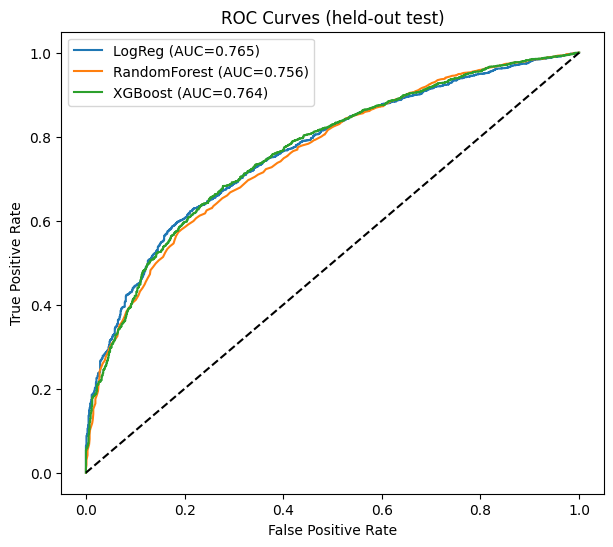

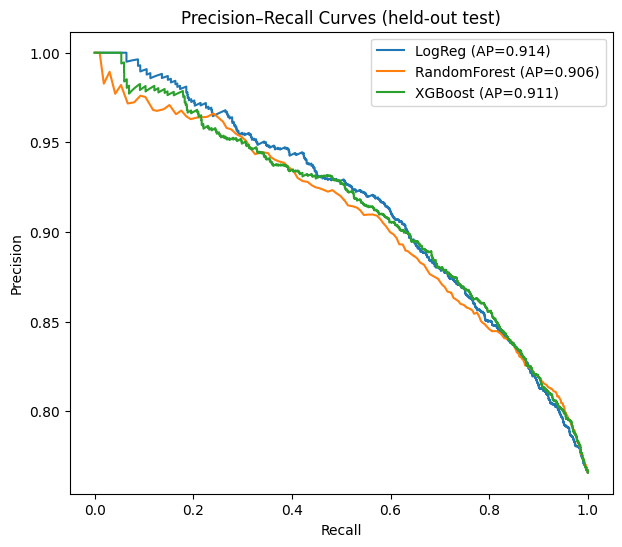

In [9]:
# =========================
# 9) Test ROC & PR curves
# =========================
plt.figure(figsize=(7,6))
for name, model in fitted.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (held-out test)"); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for name, model in fitted.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(rec, prec, label=f"{name} (AP={average_precision_score(y_test, y_prob):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves (held-out test)"); plt.legend(); plt.show()

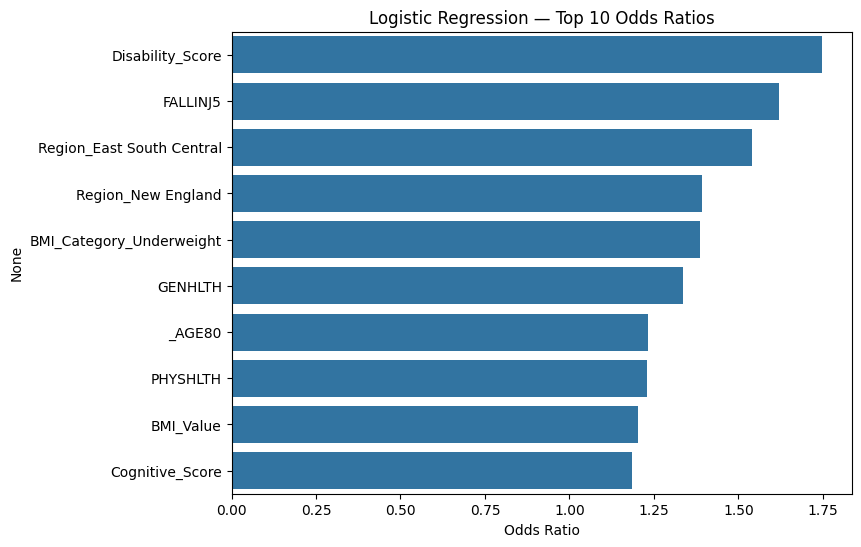

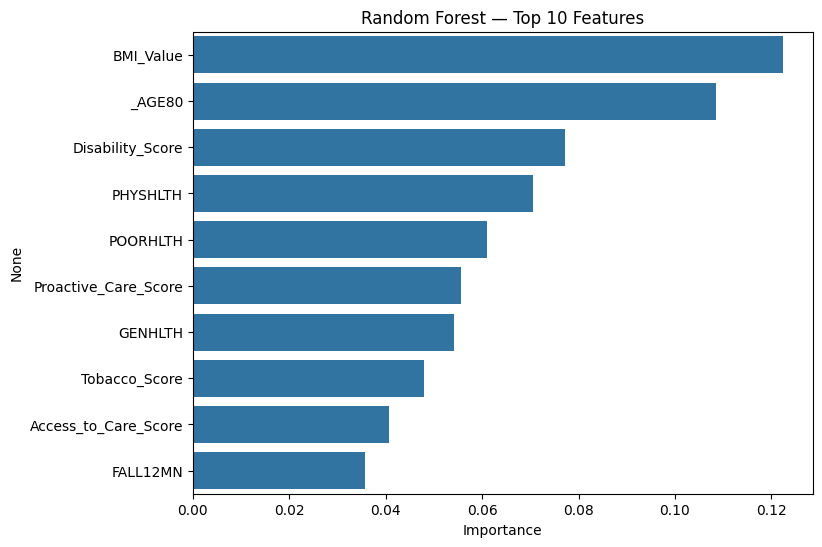

In [10]:
# =========================
# 10) Quick interpretability (global)
# =========================
# Build feature names post-transform for LR/RF bars
oh = fitted["LogReg"].named_steps["prep"].transformers_[1][1].named_steps["onehot"]
oh_names = oh.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + oh_names

# LR odds ratios (top 10 by magnitude)
lr_coefs = fitted["LogReg"].named_steps["clf"].coef_[0]
lr_or = pd.Series(np.exp(lr_coefs), index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=lr_or.head(10).values, y=lr_or.head(10).index, orient="h")
plt.xlabel("Odds Ratio"); plt.title("Logistic Regression — Top 10 Odds Ratios")
plt.show()

# RF feature importance (top 10)
rf_imp = pd.Series(fitted["RandomForest"].named_steps["clf"].feature_importances_,
                   index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=rf_imp.head(10).values, y=rf_imp.head(10).index, orient='h')
plt.xlabel("Importance"); plt.title("Random Forest — Top 10 Features")
plt.show()

# (Optional) XGB SHAP – can be run in evaluation notebook if preferred
# import shap
# explainer = shap.TreeExplainer(fitted["XGBoost"].named_steps["clf"])
# X_test_tx = fitted["XGBoost"].named_steps["prep"].transform(X_test)
# shap_values = explainer(X_test_tx)
# shap.summary_plot(shap_values, X_test_tx, feature_names=feature_names)



In [11]:
# =========================
# 11) Save models & test split for evaluation notebook
# =========================
joblib.dump(fitted["LogReg"], "model_logreg.pkl")
joblib.dump(fitted["RandomForest"], "model_rf.pkl")
joblib.dump(fitted["XGBoost"], "model_xgb.pkl")
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("\nSaved: model_logreg.pkl, model_rf.pkl, model_xgb.pkl, X_test.csv, y_test.csv")



Saved: model_logreg.pkl, model_rf.pkl, model_xgb.pkl, X_test.csv, y_test.csv
